In [1]:
using JuMP, Gurobi
using LinearAlgebra
using Distributions, Random, PDMats
using MLJ, Tables
using DataFrames, DataFramesMeta
using JLD, CSV
using PlotlyJS
using Pipe
using LaTeXStrings

Random.seed!(42)

TaskLocalRNG()

In [2]:
using Revise

includet("../models/forward.jl")
import .Forward as Forward

includet("../models/inversedemand.jl")
import .InverseDemand as IODemand

includet("../models/inverselinreg.jl")
import .InverseLinReg as IOLinReg

includet("../datagen/data-generation.jl")
import .DataGeneration as DataGen

In [3]:
Linear = @MLJ.load LinearRegressor pkg = "MLJLinearModels"


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


import MLJLinearModels ✔

MLJLinearModels.LinearRegressor

In [37]:
Random.seed!(42)

TaskLocalRNG()

In [94]:
u_1 = 20
u_2 = u_3 = 1000

n_points = 50

dist_phi = Uniform(-5, 5)
phis_1 = rand(dist_phi, n_points)
phis_2 = rand(dist_phi, n_points)

intercept_1 = 16
intercept_2 = 30

slope_1 = 0.5
slope_2 = 4

std_dev = 1
noises_1 = rand(Normal(0, std_dev^2), n_points)
noises_2 = rand(Normal(0, std_dev^2), n_points)

demands_1 = intercept_1 .+ slope_1 .* phis_1 .+ noises_1
demands_2 = intercept_2 .+ slope_2 .* phis_2 .+ noises_2

df_1 = DataFrame(:intercept_1 => fill(1.0, n_points), :intercept_2 => fill(0.0, n_points), :phi => phis_1, :demand => demands_1)
df_2 = DataFrame(:intercept_1 => fill(0.0, n_points), :intercept_2 => fill(1.0, n_points), :phi => phis_2, :demand => demands_2)

df = vcat(df_1, df_2)
first(df, 5)

Row,intercept_1,intercept_2,phi,demand
,Float64,Float64,Float64,Float64
1,1.0,0.0,-2.60686,14.577
2,1.0,0.0,1.40939,17.4861
3,1.0,0.0,3.50466,16.8774
4,1.0,0.0,2.37349,18.5603
5,1.0,0.0,-4.5849,14.8923


In [95]:
y, X = unpack(df, ==(:demand), colname -> true);

In [97]:
l_model = Linear(fit_intercept=false)
l_mach = machine(l_model, X, y) 

fit!(l_mach);
l_model_int1, l_model_int2, l_model_slope = getindex.(fitted_params(l_mach).coefs, 2)

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492
┌ Info: Solver: MLJLinearModels.Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/luca/.julia/packages/MLJLinearModels/zSQnL/src/mlj/interface.jl:27


3-element Vector{Float64}:
 14.895882498254768
 28.99092700222737
  2.1935805534783257

In [98]:
max_phi, min_phi = extrema(df.phi)
x_cap = [min_phi, max_phi]
y_cap = fill(u_1, length(x_cap));

y_l_model_com1 = l_model_int1 .+ l_model_slope .* x_cap
y_l_model_com2 = l_model_int2 .+ l_model_slope .* x_cap

2-element Vector{Float64}:
 39.83920590874395
 18.186887506734905

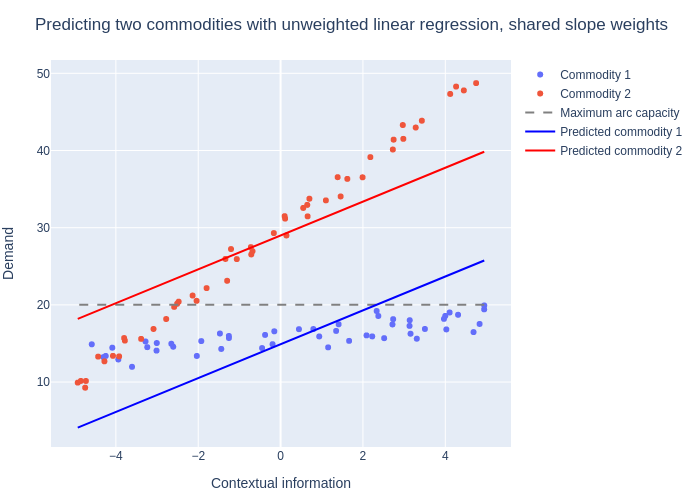

In [123]:
plot([
    scatter(x=phis_1, y=demands_1, name="Commodity 1", mode="markers"), 
    scatter(x=phis_2, y=demands_2, name="Commodity 2", mode="markers"),
    scatter(x=x_cap, y=y_cap, name="Maximum arc capacity", mode="lines", line=attr(color="gray", dash="dash")),
    scatter(x=x_cap, y=y_l_model_com1, name="Predicted commodity 1", mode="lines", line=attr(color="blue")),
    scatter(x=x_cap, y=y_l_model_com2, name="Predicted commodity 2", mode="lines", line=attr(color="red")),

    ],
    Layout(
        xaxis_title="Contextual information", 
        yaxis_title="Demand",
        title="Predicting two commodities with unweighted linear regression, shared slope weights"),
)

In [112]:
LinearW = @MLJ.load LinearRegressor pkg = "GLM"


import MLJGLMInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/luca/.julia/packages/MLJModels/Ft0z9/src/loading.jl:159


MLJGLMInterface.LinearRegressor

In [118]:
com1_weight = 4.0
weights = vcat(fill(com1_weight, n_points), fill(1.0, n_points))

w_model = LinearW(fit_intercept=false)
w_mach = machine(w_model, X, y, weights) 

fit!(w_mach);
w_model_int1, w_model_int2, w_model_slope = fitted_params(w_mach).coef

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/luca/.julia/packages/MLJBase/kK4C2/src/machines.jl:492


3-element Vector{Float64}:
 15.46892949663143
 28.47000354156587
  1.158081560857485

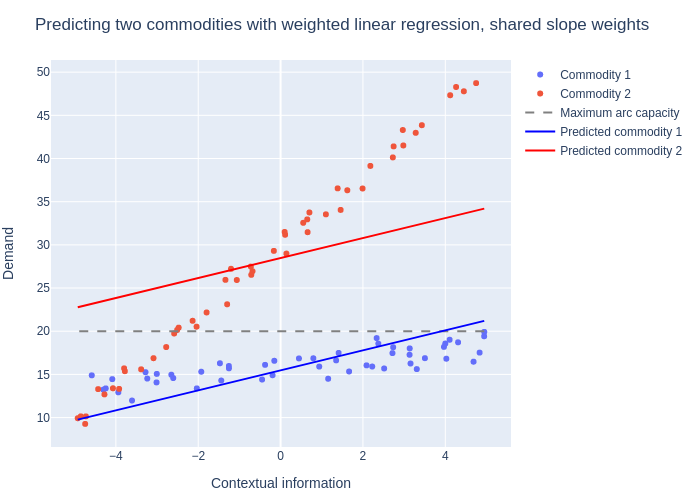

In [121]:
y_w_model_com1 = w_model_int1 .+ w_model_slope .* x_cap
y_w_model_com2 = w_model_int2 .+ w_model_slope .* x_cap

plot([
    scatter(x=phis_1, y=demands_1, name="Commodity 1", mode="markers"), 
    scatter(x=phis_2, y=demands_2, name="Commodity 2", mode="markers"),
    scatter(x=x_cap, y=y_cap, name="Maximum arc capacity", mode="lines", line=attr(color="gray", dash="dash")),
    scatter(x=x_cap, y=y_w_model_com1, name="Predicted commodity 1", mode="lines", line=attr(color="blue")),
    scatter(x=x_cap, y=y_w_model_com2, name="Predicted commodity 2", mode="lines", line=attr(color="red")),

    ],
    Layout(
        xaxis_title="Contextual information", 
        yaxis_title="Demand",
        title="Predicting two commodities with weighted linear regression, shared slope weights"),
)